In [257]:
import os
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.losses  import SparseCategoricalCrossentropy

import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
from keras.utils import to_categorical
import itertools

import warnings
warnings.simplefilter('ignore')

In [217]:
def load_mnist():
  mnist = loadmat("/content/drive/MyDrive/Machine Learning Specialization/MNIST digits classification dataset/mnist-original.mat/mnist-original.mat")
  mnist_data = mnist["data"].T
  mnist_data = mnist_data.reshape(len(mnist_data), 28, 28, 1)
  mnist_label = mnist["label"][0]
  count = len(set(mnist_label))
  return mnist_data, mnist_label, count, (28, 28, 1)

In [218]:
data, labels, classes_count, data_shape = load_mnist()
print("data shape: " + str(data.shape))
print("labels shape: " + str(labels.shape))
print("classes count: " + str(classes_count))

data shape: (70000, 28, 28, 1)
labels shape: (70000,)
classes count: 10


In [225]:
def plot_images_sample(X, Y):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=10)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index]) # raqamni aslini ko'rsatadi
    plt.show()

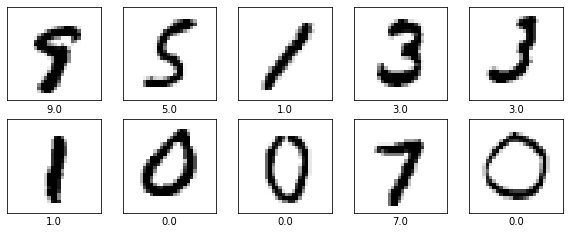

In [226]:
plot_images_sample(data, labels)

### Scaling data, splut and transform target to categorical

In [227]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, shuffle=True)

In [232]:
def fe_data(df, target):
    # FE: scaling data ant transform target to categorical
    df = df / 255.
    target = to_categorical(target)
    return df, target

In [233]:
X_train, Y_train = fe_data(x_train, y_train)
X_test, Y_test = fe_data(x_test, y_test)

### Model training

In [260]:
model = models.Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', input_shape = data_shape))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(BatchNormalization()) 
model.add(Conv2D(256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(BatchNormalization()) 
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(classes_count, activation = 'softmax'))

In [261]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                     

In [264]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [287]:
history = model.fit(X_train, Y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
1575/1575 [==============================] - 415s 263ms/step - loss: 0.0394 - accuracy: 0.9892 - val_loss: 0.0553 - val_accuracy: 0.9843
Epoch 2/5
1575/1575 [==============================] - 411s 261ms/step - loss: 0.0291 - accuracy: 0.9918 - val_loss: 0.0457 - val_accuracy: 0.9879
Epoch 3/5
1575/1575 [==============================] - 409s 260ms/step - loss: 0.0270 - accuracy: 0.9924 - val_loss: 0.0416 - val_accuracy: 0.9897
Epoch 4/5
1575/1575 [==============================] - 425s 270ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.0568 - val_accuracy: 0.9854
Epoch 5/5
1575/1575 [==============================] - 429s 273ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.0408 - val_accuracy: 0.9917


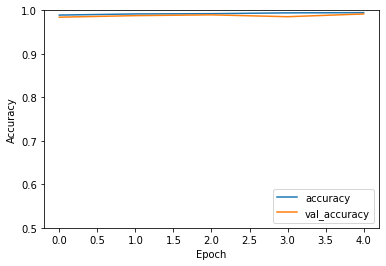

In [288]:
# Draw plot for CNN training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [289]:
# Print test prediction accuracy
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("test accuracy: " + str(test_acc))

219/219 - 12s - loss: 0.0434 - accuracy: 0.9906 - 12s/epoch - 56ms/step
test accuracy: 0.9905714392662048


In [290]:
def get_predictions(X_test):
    # Digits prediction

    predictions = model.predict(X_test)    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

219/219 [==============================] - 13s 59ms/step


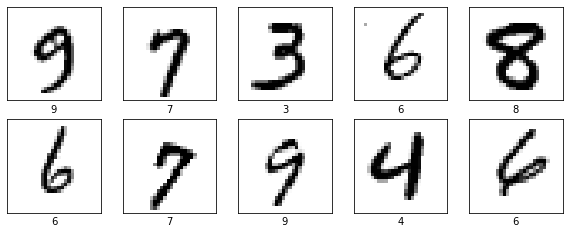

In [291]:
# Prediction and display it
predictions = get_predictions(X_test)
plot_images_sample(X_test, predictions)

In [292]:
def pred_wrong_display_MNIST_dataset(X_test, predictions, Y_test):
    # Displays misclassified digits from MNIST dataset
    
    X_test_wrong = []
    predictions_wrong = []
    Y_test_pred = []
    for i in range(len(X_test)):
        Y_test_pred.append(np.argmax(Y_test[i]))
        if predictions[i] != Y_test_pred[i]:
            #print(i, predictions[i], Y_test_pred[i])
            X_test_wrong.append(X_test[i])
            predictions_wrong.append(predictions[i])

    plot_images_sample(X_test_wrong, predictions_wrong)
        
    print('Accuracy is', round(accuracy_score(Y_test_pred, predictions),3))
    
    return Y_test_pred

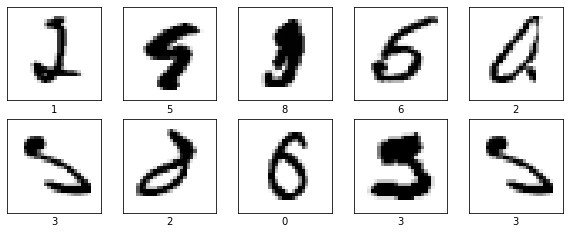

Accuracy is 0.991


In [293]:
# Displays misclassified digits from MNIST
Y_test_pred = pred_wrong_display_MNIST_dataset(X_test, predictions, Y_test)

In [294]:
model.save('/content/drive/MyDrive/Machine Learning Specialization/MNIST digits classification dataset/model')  

In [295]:
model_load = tf.keras.models.load_model('/content/drive/MyDrive/Machine Learning Specialization/MNIST digits classification dataset/model')

In [296]:
def get_predictions_load(X_test):
    # Digits prediction

    predictions = model_load.predict(X_test)    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

1/1 [==============================] - 0s 31ms/step


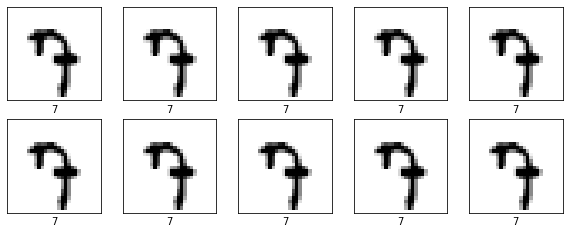

In [297]:
predictions = get_predictions(X_test[0:1])
plot_images_sample(X_test[0:1], predictions)  

In [284]:
X_test[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [ ]:
import base64
import json
import os
import re
import time
import uuid
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
import streamlit as st
from PIL import Image
from streamlit_drawable_canvas import st_canvas
from svgpathtools import parse_path


def main():
    if "button_id" not in st.session_state:
        st.session_state["button_id"] = ""
    if "color_to_label" not in st.session_state:
        st.session_state["color_to_label"] = {}
    PAGES = {
        "Basic example": full_app,
        "Download Base64 encoded PNG": png_export,
    }
    page = st.sidebar.selectbox("Page:", options=list(PAGES.keys()))
    PAGES[page]()

    with st.sidebar:
        st.markdown("---")
        st.markdown(
            '<h6>Made in &nbsp<img src="https://streamlit.io/images/brand/streamlit-mark-color.png" alt="Streamlit logo" height="16">&nbsp by <a href="https://twitter.com/andfanilo">@andfanilo</a></h6>',
            unsafe_allow_html=True,
        )
        st.markdown(
            '<div style="margin: 0.75em 0;"><a href="https://www.buymeacoffee.com/andfanilo" target="_blank"><img src="https://cdn.buymeacoffee.com/buttons/default-orange.png" alt="Buy Me A Coffee" height="41" width="174"></a></div>',
            unsafe_allow_html=True,
        )

def full_app():
    st.sidebar.header("Configuration")

    with st.echo("below"):
        # Specify canvas parameters in application
        drawing_mode = st.sidebar.selectbox(
            "Drawing tool:",
            ("freedraw", "line", "rect", "circle", "transform", "polygon", "point"),
        )
        stroke_width = st.sidebar.slider("Stroke width: ", 1, 25, 3)
        if drawing_mode == 'point':
            point_display_radius = st.sidebar.slider("Point display radius: ", 1, 25, 3)
        stroke_color = st.sidebar.color_picker("Stroke color hex: ")
        bg_color = st.sidebar.color_picker("Background color hex: ", "#eee")
        bg_image = st.sidebar.file_uploader("Background image:", type=["png", "jpg"])
        realtime_update = st.sidebar.checkbox("Update in realtime", True)

        # Create a canvas component
        canvas_result = st_canvas(
            fill_color="rgba(255, 165, 0, 0.3)",  # Fixed fill color with some opacity
            stroke_width=stroke_width,
            stroke_color=stroke_color,
            background_color=bg_color,
            background_image=Image.open(bg_image) if bg_image else None,
            update_streamlit=realtime_update,
            height=150,
            drawing_mode=drawing_mode,
            point_display_radius=point_display_radius if drawing_mode == 'point' else 0,
            display_toolbar=st.sidebar.checkbox("Display toolbar", True),
            key="full_app",
        )

        # Do something interesting with the image data and paths
        if canvas_result.image_data is not None:
            st.image(canvas_result.image_data)
        if canvas_result.json_data is not None:
            objects = pd.json_normalize(canvas_result.json_data["objects"])
            for col in objects.select_dtypes(include=["object"]).columns:
                objects[col] = objects[col].astype("str")
            st.dataframe(objects)

def png_export():
    st.markdown(
        """
    Realtime update is disabled for this demo. 
    Press the 'Download' button at the bottom of canvas to update exported image.
    """
    )
    try:
        Path("tmp/").mkdir()
    except FileExistsError:
        pass

    # Regular deletion of tmp files
    # Hopefully callback makes this better
    now = time.time()
    N_HOURS_BEFORE_DELETION = 1
    for f in Path("tmp/").glob("*.png"):
        st.write(f, os.stat(f).st_mtime, now)
        if os.stat(f).st_mtime < now - N_HOURS_BEFORE_DELETION * 3600:
            Path.unlink(f)

    if st.session_state["button_id"] == "":
        st.session_state["button_id"] = re.sub(
            "\d+", "", str(uuid.uuid4()).replace("-", "")
        )

    button_id = st.session_state["button_id"]
    file_path = f"tmp/{button_id}.png"

    custom_css = f""" 
        <style>
            #{button_id} {{
                display: inline-flex;
                align-items: center;
                justify-content: center;
                background-color: rgb(255, 255, 255);
                color: rgb(38, 39, 48);
                padding: .25rem .75rem;
                position: relative;
                text-decoration: none;
                border-radius: 4px;
                border-width: 1px;
                border-style: solid;
                border-color: rgb(230, 234, 241);
                border-image: initial;
            }} 
            #{button_id}:hover {{
                border-color: rgb(246, 51, 102);
                color: rgb(246, 51, 102);
            }}
            #{button_id}:active {{
                box-shadow: none;
                background-color: rgb(246, 51, 102);
                color: white;
                }}
        </style> """

    data = st_canvas(update_streamlit=False, key="png_export")
    if data is not None and data.image_data is not None:
        img_data = data.image_data
        im = Image.fromarray(img_data.astype("uint8"), mode="RGBA")
        im.save(file_path, "PNG")

        buffered = BytesIO()
        im.save(buffered, format="PNG")
        img_data = buffered.getvalue()
        try:
            # some strings <-> bytes conversions necessary here
            b64 = base64.b64encode(img_data.encode()).decode()
        except AttributeError:
            b64 = base64.b64encode(img_data).decode()

        dl_link = (
            custom_css
            + f'<a download="{file_path}" id="{button_id}" href="data:file/txt;base64,{b64}">Export PNG</a><br></br>'
        )
        st.markdown(dl_link, unsafe_allow_html=True)

if __name__ == "__main__":
    st.set_page_config(
        page_title="Streamlit Drawable Canvas Demo", page_icon=":pencil2:"
    )
    st.title("Drawable Canvas Demo")
    st.sidebar.subheader("Configuration")
    main()
